<div class="alert alert-danger">

**Read the `Instructions` notebook** before you start working on this problem set! If you need more details on the *BayesNet* class, have a look at the `BayesNet Introduction` notebook of Problem Set 2.
    
</div>

**General Remarks**:
- Do not delete or add cells.
- Store your results into the corresponding result variables or implement the provided function stubs.
- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from bayesian_network import BayesNet, Variable
from utils import maximum_likelihood_estimate, log_likelihood, get_default_bayes_net, draw_graph, evaluate_bayes_net


#  Structure Learning

This notebook will implement a function that learns the *structure* and *parameters* of a Bayesian net using *score-based search over a search space restricted by a pre-determined variable order*. We will then use this function to automatically find a good graph structure for the stroke example from the previous assignment.


#### General Remarks

Since we are dealing with a graph structure, we need to store it in some way. We do it using two lists, which can also be used to initialize a *BayesNet* object:
  - One list contains the (conditional) Probability Distribution Tables (PDTs) of the variables; this list will usually be called `pdts` in this notebook.
  - The second list contains tuples of indices that denote to which columns in the data the dimensions of the corresponding PDTs belong. This list will usually be called `indices` in this notebook.
  
For example, assume we have three random variables A, B, and C. The data is stored accordingly. Further assume we want to encode the model that factorizes in the following way:

$$ P(A, B, C) = P(A) \cdot P(B \mid A) \cdot P(C \mid A, B).$$

Variables $A, B$ and $C$ will get indices 0, 1, and 2, respectively. The two lists will then look like this (following the same naming conventions as used in the previous exercises):

In [2]:
_A_, _B_, _C_ = 0, 1, 2
# create dummy PDTs
pdts = [
    (np.ones((2,))*0.5, (_A_,)), 
    (np.ones((2,2))*0.5, (_B_, _A_)), 
    (np.ones((2,2,2))*0.5, (_C_, _A_, _B_))
]

A new BayesNet can be created by passing a tuple for each variable to the constructor: 
 - the first element in each tuple contains the (conditional) PDTs, 
 - the second one the tables' semantics (indices).
 - use the asterisk (\*) operator to pass an arbitrary number of tuples as arguments to the constructor

In [3]:
bn = BayesNet(*pdts)

You can access the PDTs and the corresponding indices of a *BayesNet* object via the member variables `pdts` and `indices`, respectively:

In [4]:
print(bn.pdts)
print(bn.indices)

(array([0.5, 0.5]), array([[0.5, 0.5],
       [0.5, 0.5]]), array([[[0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5]]]))
((0,), (1, 0), (2, 0, 1))


Note that they are returned as tuples, to make clear they should not be modified. With `list(bn.pdts)` and `list(bn.indices)` you can convert them back to lists if needed.

We are also providing a new utility function to draw the structure of a BayesNet:

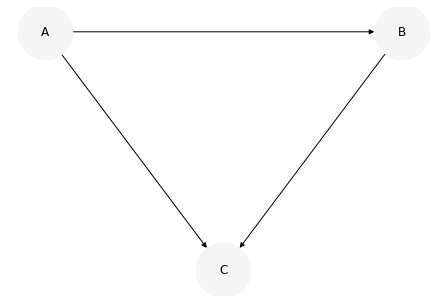

In [5]:
draw_graph(
    bn, 
    node_names=['A', 'B', 'C'], 
    pos={'A': [0., 1.], 'B': [1., 1.], 'C': [.5, .5]}
)

In [6]:
help(draw_graph)

Help on function draw_graph in module utils:

draw_graph(bayes_net: bayesian_network.BayesNet, node_names: list = None, pos: dict = None) -> None
    Draws the Bayesian net.
    :param bayes_net: a BayesNet object representing the graph structure to draw.
    :param node_names: Display Name of the variables. 
                       Defaults to values for the stroke-example.
    :param pos: position of the variables (dict: key=variable_name, value: list: x, y). 
                Defaults to values for the stroke-example.



### Bayes Information Criterion

<div class="alert alert-warning">
    Implement the <i>bic_score</i> function, which computes the Bayes Information Criterion Score (BIC-Score) for a network graph structure under the given data, assuming a Dirichlet prior over the model parameters. (4 points)
</div>

`bic_score` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bayes_net` is a BayesNet object, representing the graph structure for which to compute the BIC-Score. *Assume that the parameters of this bayes_net are set to the maximum likelihood estimate w.r.t. to the data*.

`bic_score` must return one object:
- The BIC-Score, a floating-point number < 0.


*Hint*:
- **You *may* assume that all variables are boolean.**
- Use the formula from the lecture slides (slide deck 5b, pp. 48-51)!
- The dimension of a Bayes net is the total number of independent (non-redundant) parameters in the Bayes net.
- Use the natural logarithm for your computations, i.e. `np.log`.
- You can use `Variable.num_values` to fetch the cardinality of a Variable. This is especially helpful for a general solution, where Variables can have more than 2 values. 
- Use our implementation of `log_likelihood` (see below) to compute the log-likelihood of the model relative to the data.

In [7]:
help(log_likelihood)

Help on function log_likelihood in module utils:

log_likelihood(data: numpy.ndarray, bayes_net: bayesian_network.BayesNet) -> float
    Computes the log-likelihood of a given Bayesian network relative to the data.
    :param data: data to compute the log-likelihood relative to.
    :param bayes_net: Bayesian network model.
    :returns: the log-likelihood of the Bayesian network relative to the data.



In [8]:
def bic_score(data: np.ndarray, bayes_net: BayesNet) -> float:
    """
    Computes the Bayesian information criterion score assuming a Dirichlet prior over the model parameters.
    :param data:      data to compute the bic score of, a np.ndarray of shape (num_samples, len(bayes_net)).
    :param bayes_net: the model, a BayesNet object.
    :return:          BIC score
    """
    
    assert data.shape[1] == len(bayes_net)
    
    bic = 0
    
    # YOUR CODE HERE
    # calculate the number of independant parameters in G (the network graph structure) -> model dimension
    count_ip = 0
    
    for var in bayes_net:
        num_pars = var.num_values - 1
        for i in var.parents:
            num_pars *= bayes_net[i].num_values
        count_ip += num_pars
    
    # First term, describes how well the model fits to the data
    score_fit_to_data = log_likelihood(data, bayes_net) 
    # Calculate the regularisation term (penalty on large model complexity)
    regularisation_term = np.log(len(data))/2 * count_ip
    
    bic = score_fit_to_data - regularisation_term
    return bic

In [9]:
# sanity check
bayes_net = get_default_bayes_net()
data = np.array([[0,0,0,0,0], [1,1,1,1,1], [1,1,0,0,0]], dtype=np.int64)

bic = bic_score(data, bayes_net)
assert isinstance(bic,float), f'`bic_score` should return type float but returns {type(bic)}'
assert -16 < bic < -15, f'BIC needs to be in ]-16, -15[, but got {bic}'



### Score Based Search
<div class="alert alert-warning">
Implement <i>learn_net</i>, a function that learns the structure and parameters of a Bayesian net using score-based search over a search space restricted by a pre-determined variable order. (6 points)
</div>

`learn_net` takes three parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `variable_order` is a list of variable ids (ints) specifying the topological order.
- `score_fun` is the function used to score the candidate graph structure — defaults to `bic_score`. Higher score means better model. 

`learn_net` must return one object:
- a BayesNet object, which represents the model with the highest score under the given topological order.

*Hints:*
- Use `score_fun` to compute the score. Do not directly call your implementation of `bic_score`.
- You may use [`itertools.combinations`](https://docs.python.org/3/library/itertools.html#itertools.combinations) to get combinations of parent variables. For the N-th variable in `variable_order`, there are exactly $2^{N-1}$ possible parent sets to be considered.
- [`itertools.chain.from_iterable`](https://docs.python.org/3/library/itertools.html#itertools.chain.from_iterable) might become handy for flattening lists of lists of variable indexes.
- Mind that python-objects, such as lists, are passed by reference; updating a value in the list will affect all objects holding the reference! To avoid unintended change, create a copy of the list before you modify it:
```python
best_pdts.copy()
```
- Use a BayesNet only consisting of independent Variables (e.g. no connections) as starting point. Iteratively compare it with other ones and always keep the best.
- Use the provided implementation of `maximum_likelihood_estimate` to estimate the parameters of a table:

In [10]:
help(maximum_likelihood_estimate)

Help on function maximum_likelihood_estimate in module utils:

maximum_likelihood_estimate(data: numpy.ndarray, variable_id: int, parent_ids: tuple = (), laplace=1) -> numpy.ndarray
    Estimates the conditional probability distribution of a (discrete) variable from data.
    :param data:    data to estimate distribution from
    :param variable_id:  column index corresponding to the variable we estimate the distribution for
    :param parent_ids: column indices of the variables the distribution is conditioned on
    :param laplace: Laplace smoothing with this alpha.
    :returns: estimated conditional probability distribution table



In [11]:
import itertools as it
import copy

def learn_net(data: np.ndarray, variable_order: list, score_fun: Callable[[np.ndarray, BayesNet], float]=bic_score) -> BayesNet:
    """
    Learns the structure and parameters of a Bayesian net using score-based search over a search space restricted by a pre-determined variable order.
    :param data: the training data, a NumPy array of shape (num_samples, len(bayes_net)).
    :param variable_order: a list containing the topological order of the variables (list of indices).
    :param score_fun:  is the function used to score the candidate graph structure — defaults to `bic_score`. 
    :return: a BayesNet object, which represents the model with the highest BIC-Score under the given topological order.
    """
    assert len(variable_order) == data.shape[1]
    
    best_pdts = [maximum_likelihood_estimate(data, variable_id) for variable_id in variable_order]
    best_indices = [(variable_id,) for variable_id in variable_order]
    # you can create a BayesNet from these descriptors with:
    best_model = BayesNet(*zip(best_pdts, best_indices))
    
    # YOUR CODE HERE
    for i, var_id in enumerate(variable_order):
        #print(variable_order[:i], len(variable_order[:i])+1)
        all_combinations = [it.combinations(variable_order[:i], p) for p in range(1, len(variable_order[:i])+1)]
        
        for par_id in it.chain.from_iterable(all_combinations):
            local_pdts = best_pdts.copy()
            local_indices = best_indices.copy()
            
            local_pdts[i] = maximum_likelihood_estimate(data, var_id, par_id)
            local_indices[i] = (var_id,) + par_id
            
            local_model = BayesNet(*zip(local_pdts, local_indices))
            
            local_score = score_fun(data, local_model)
            best_score = score_fun(data, best_model)
            if local_score > best_score:
                #print(local_score, best_score, local_indices[i])
                best_pdts = local_pdts
                best_indices = local_indices
                best_model = local_model
                
            
    return best_model

In [12]:
data = np.array([[0,0,0,0,1],[0,0,0,1,0],[0,1,0,1,0],[1,0,0,1,0],[0,1,0,0,1],[1,0,0,0,1]]*10, dtype=np.int64)
bayes_net = learn_net(data, [0,1,2,3,4])
assert len(bayes_net) == 5, f'\nBayesNet should contain all 5 Variables.' \
                            f'\nIt only contained {len(bayes_net)} being {set(it.chain(*bayes_net.indices))}.'\
                            f'\nMissing: {set(range(5))-set(it.chain(*bayes_net.indices))}.'\
                            f'\nMost likely there is an error in how you construct your `new` BayesNet during learning.'

assert np.all(np.isclose(bayes_net.pdts[0], np.array([0.66, 0.33]), atol=0.01))
assert bayes_net.indices[1] == (1,0), 'Algorithm should favor connection B_A'

bayes_net = learn_net(data, [0,1,2,3,4], score_fun=lambda d, n: 0.0)
assert bayes_net.indices[1] == (1,), 'it seems learn_net() uses bic_score() instead of score_fun()'


## Example

---


Consider the same model as in problem set 3, comprising the following random variables:

 - A ... Alcoholism
 - H ... High Blood Pressure
 - S ... Stroke
 - C ... Confusion
 - V ... Vertigo
 
Instead of trying different model structures manually, our medicine freshman wants the computer to determine the best structure automatically. To this end, she asks her computer science colleagues to get even more data from the university clinic systems. They give her four data sets of different sizes ("train_small.txt", "train_medium.txt", "train_big.txt", and "test.txt").


In [13]:
_A_, _H_, _S_, _C_, _V_ = 0, 1, 2, 3, 4

train_small = np.loadtxt('data/train_small.txt', dtype=np.int64)
train_medium = np.loadtxt('data/train_medium.txt', dtype=np.int64)
train_big = np.loadtxt('data/train_big.txt', dtype=np.int64)
test = np.loadtxt('data/test.txt', dtype=np.int64)

model2_ps3_indices = [(_A_,), (_H_, _A_), (_S_, _H_), (_C_, _A_, _S_), (_V_, _S_)]


She decides to use *score-based search* to find the best model. She wants to *define a variable order* to restrict the search space strongly. She considers the following configurations:

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Variable Order</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Score Function</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">V, C, S, H, A</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">C, A, H, V, S<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Log-Likelihood</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">PS2, Model 2 (defined below)</td></tr></table>

<div class="alert alert-warning">
    
Use the `learn_net` function to learn a graph structure and the parameters for the different configurations and for all data sets (`train_small`, `train_medium`, and `train_big`). Store the bayes_net objects into the provided result variable `models` and visualize the learned graph structures with `draw_graph(bayes_net)`. Use this section to analyze the results more deeply! (4 points)
</div>

*Hints:*
- You can use `log_likelihood` as a scoring function by overwriting the default choice for the named parameter `score_fun` of `learn_net`, e.g.,
```python
learn_net(data, order, score_fun=log_likelihood)
```
- Model 2 of PS3 is represented by the PDT $P(A)$, $P(H\mid A)$, $P(S\mid H)$, $P(C\mid A, S)$, and $P(V\mid S)$. The indices are stored in `model2_ps3_indices`. Estimate the PDT from the data sets (MLE) and create the BayesNet object.
```python
pdts = [maximum_likelihood_estimate(data, indices[0], indices[1:]) for indices in model2_ps3_indices]
model2_ps3 = BayesNet(*zip(pdts, model2_ps3_indices))
```

In [14]:
model2_ps3_indices = [(_A_,), (_H_, _A_), (_S_, _H_), (_C_, _A_, _S_), (_V_, _S_)]

help(draw_graph)
help(evaluate_bayes_net)

Help on function draw_graph in module utils:

draw_graph(bayes_net: bayesian_network.BayesNet, node_names: list = None, pos: dict = None) -> None
    Draws the Bayesian net.
    :param bayes_net: a BayesNet object representing the graph structure to draw.
    :param node_names: Display Name of the variables. 
                       Defaults to values for the stroke-example.
    :param pos: position of the variables (dict: key=variable_name, value: list: x, y). 
                Defaults to values for the stroke-example.

Help on function evaluate_bayes_net in module utils:

evaluate_bayes_net(bayes_net: bayesian_network.BayesNet, train_set: numpy.ndarray, test_set: numpy.ndarray) -> tuple
    Computes the mean likelihood of the Bayesian network under the training and test data
    :param bayes_net: a BayesNet object, representing the model.
    :param train_set: the training set, a NumPy array of shape (num_samples, len(bayes_net)).
    :param test_set: the test set, a Numpy arry (num_s

In [15]:
### this is part of a hidden test; don't remove...

Trained ordered
Trained reverse
Trained random
Trained log-likelihood
Set size:  small ; Order:  ordered


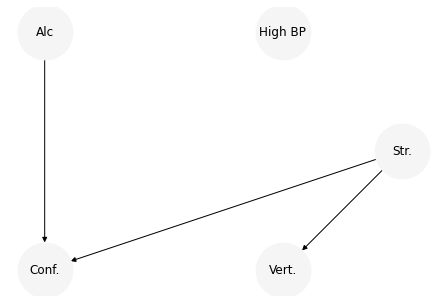

Set size:  small ; Order:  reverse


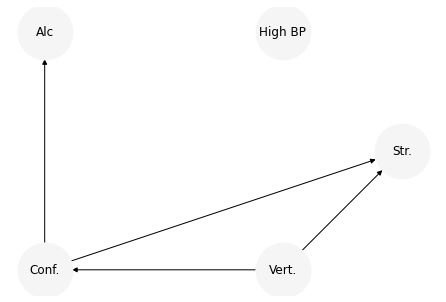

Set size:  small ; Order:  random


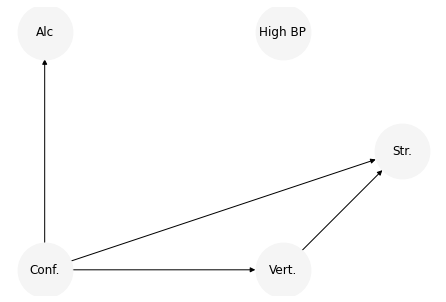

Set size:  small ; Order:  log-likelihood


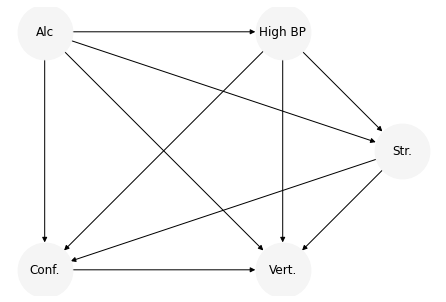

Set size:  small ; Order:  pre-defined


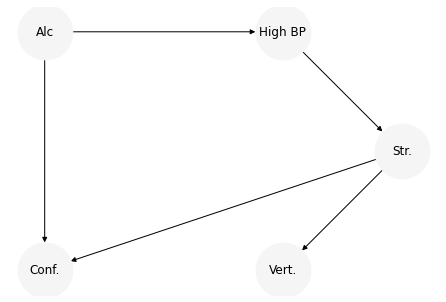

Set size:  medium ; Order:  ordered


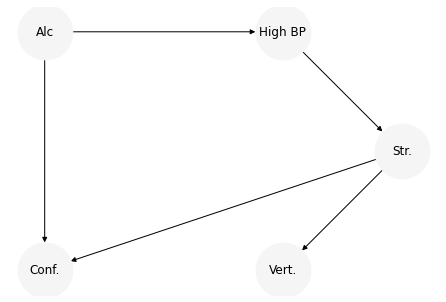

Set size:  medium ; Order:  reverse


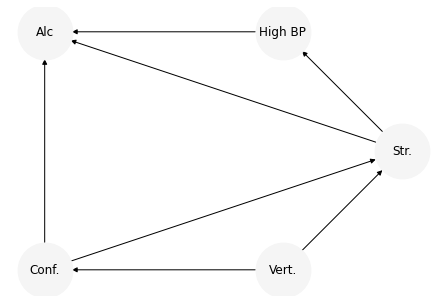

Set size:  medium ; Order:  random


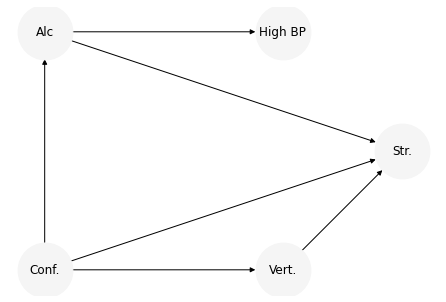

Set size:  medium ; Order:  log-likelihood


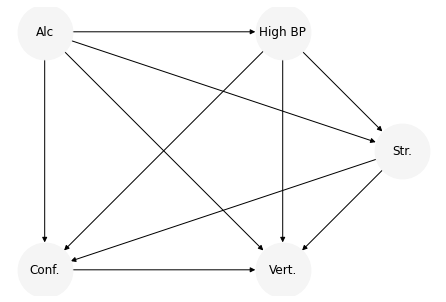

Set size:  medium ; Order:  pre-defined


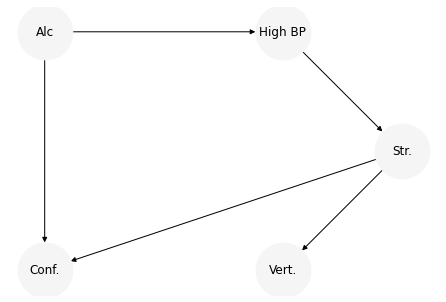

Set size:  big ; Order:  ordered


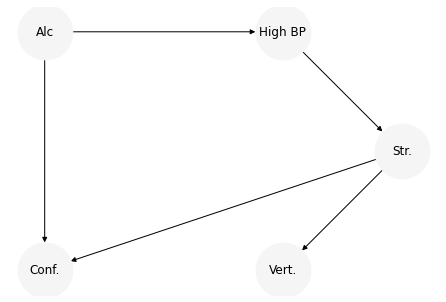

Set size:  big ; Order:  reverse


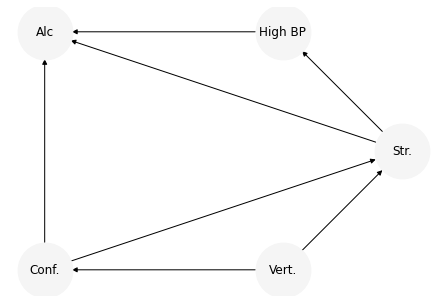

Set size:  big ; Order:  random


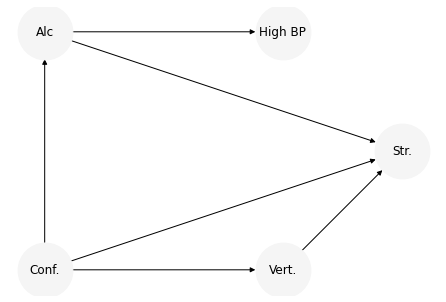

Set size:  big ; Order:  log-likelihood


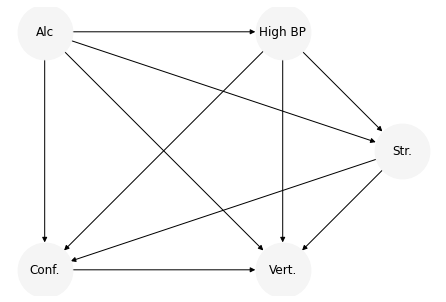

Set size:  big ; Order:  pre-defined


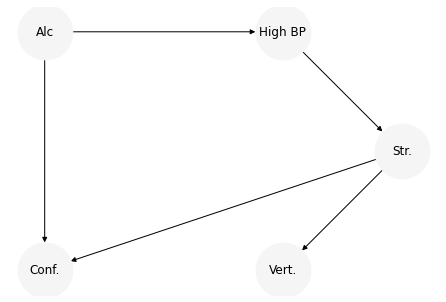

In [16]:
models = {}
for data_set_size in ['small', 'medium', 'big']:
    models[data_set_size] = {
            'ordered': None, # _A_, _H_, _S_, _C_, _V_; bic_score
            'reverse': None, # _V_, _C_, _S_, _H_, _A_; bic_score
            'random': None, # _C_, _A_, _H_, _V_, _S_; bic_score
            'log-likelihood': None, # _A_, _H_, _S_, _C_, _V_; log_likelihood
            'pre-defined': None # pre-defined structure
        }

# YOUR CODE HERE
# Ordered
models['small']['ordered'] = learn_net(train_small, (_A_, _H_, _S_, _C_, _V_))
models['medium']['ordered'] = learn_net(train_medium, (_A_, _H_, _S_, _C_, _V_))
models['big']['ordered'] = learn_net(train_big, (_A_, _H_, _S_, _C_, _V_))
print("Trained ordered")

# Reverse
models['small']['reverse'] = learn_net(train_small, (_V_, _C_, _S_, _H_, _A_))
models['medium']['reverse'] = learn_net(train_medium, (_V_, _C_, _S_, _H_, _A_))
models['big']['reverse'] = learn_net(train_big, (_V_, _C_, _S_, _H_, _A_))
print("Trained reverse")

# Random
models['small']['random'] = learn_net(train_small, (_C_, _A_, _H_, _V_, _S_))
models['medium']['random'] = learn_net(train_medium, (_C_, _A_, _H_, _V_, _S_))
models['big']['random'] = learn_net(train_big, (_C_, _A_, _H_, _V_, _S_))
print("Trained random")

# Log-Likelihood
models['small']['log-likelihood'] = learn_net(train_small, ( _A_, _H_, _S_, _C_, _V_), score_fun=log_likelihood)
models['medium']['log-likelihood'] = learn_net(train_medium, ( _A_, _H_, _S_, _C_, _V_), score_fun=log_likelihood)
models['big']['log-likelihood'] = learn_net(train_big, ( _A_, _H_, _S_, _C_, _V_), score_fun=log_likelihood)
print("Trained log-likelihood")

# Pre-Defined model
pdts = [maximum_likelihood_estimate(train_small, indices[0], indices[1:]) for indices in model2_ps3_indices]
models['small']['pre-defined'] = BayesNet(*zip(pdts, model2_ps3_indices))
pdts = [maximum_likelihood_estimate(train_medium, indices[0], indices[1:]) for indices in model2_ps3_indices]
models['medium']['pre-defined'] = BayesNet(*zip(pdts, model2_ps3_indices))
pdts = [maximum_likelihood_estimate(train_big, indices[0], indices[1:]) for indices in model2_ps3_indices]
models['big']['pre-defined'] = BayesNet(*zip(pdts, model2_ps3_indices))

# Visualize the net for each combination
for data_set_id in ['small', 'medium', 'big']:
    for combination_id in ['ordered', 'reverse', 'random', 'log-likelihood', 'pre-defined']:
        print("Set size: ", data_set_id, "; Order: ", combination_id)
        draw_graph(models[data_set_id][combination_id])

In [17]:
for data_set_id in ['small', 'medium', 'big']:
    for combination_id in ['ordered', 'reverse', 'random', 'log-likelihood', 'pre-defined']:
        assert type(models[data_set_id][combination_id]) is BayesNet
        

### Interpret the Results in Detail

Inspect the following plots:
 - In the first plot, we visualize the training set size's influence on the log-likelihood relative to the test data.

- In the second plot, we compare all configurations' log-likelihood relative to the training and test data for each dataset size.

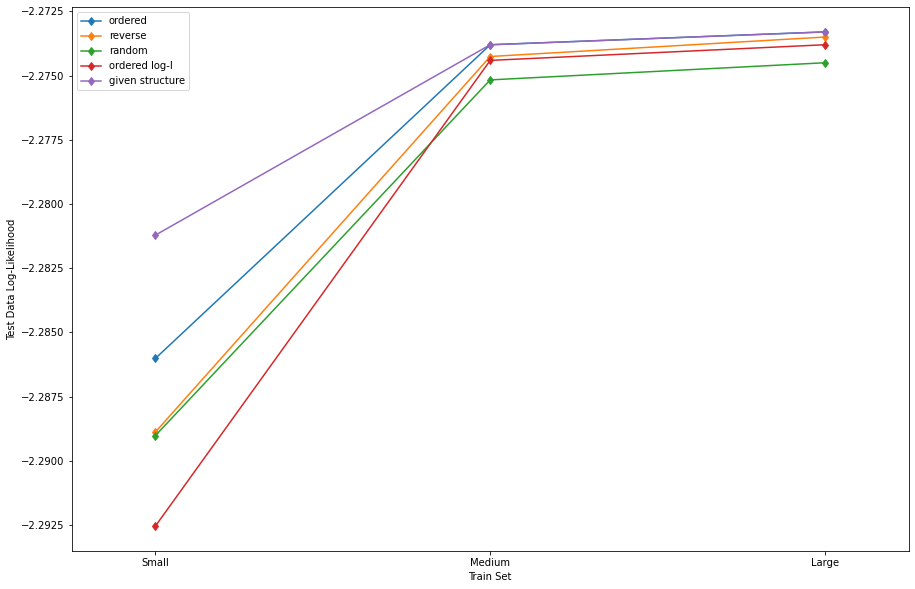

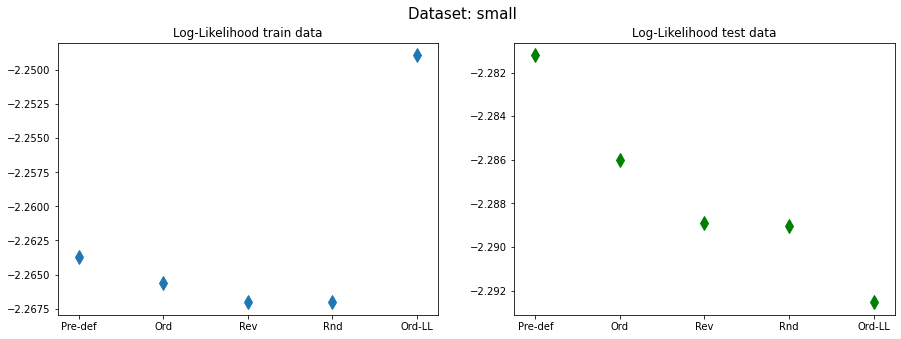

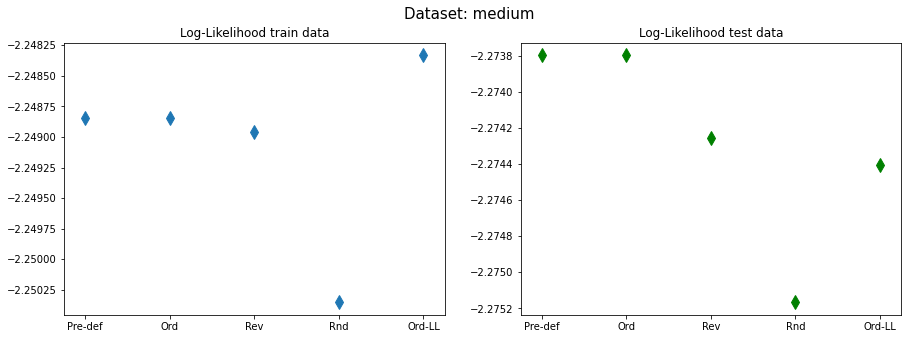

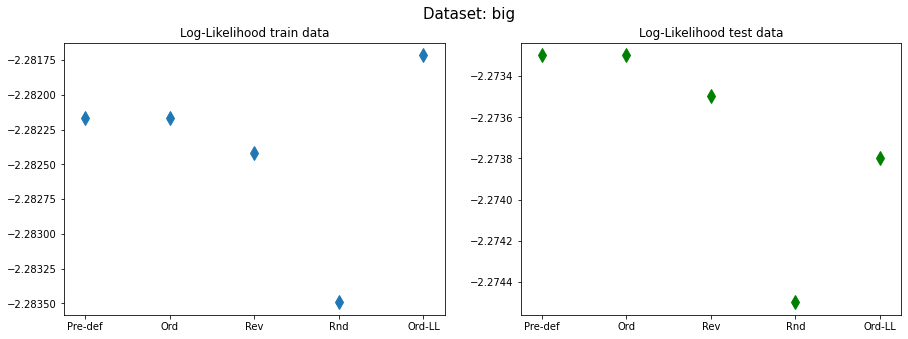

In [18]:
from utils import plot_compare_orders, compare_train_size

compare_train_size(models, [train_small, train_medium, train_big], test)
plot_compare_orders(models, [train_small, train_medium, train_big], test)


<div class="alert alert-warning">
Analyze the graphs and the plots in more detail and answer the following question *briefly*. (2 points)
</div>

What makes a variable order 'good' for score-based seach?

A variable order can be considered 'good' when the search space contains the real model we look for (the ordering is causal).

<div class="alert alert-warning">
Answer the following questions (True or False). (1 point each)
</div>

1. The pre-defined variable order gives the best results.
2. Adding an additional edge to the graph cannot decrease the Log-likelihood of the training data.
3. Using the Log-Likelihood as the scoring function will always result in a fully connected graph.
4. If we remove the log-likelihood from the BIC score, the fully connected network is most likely.
5. As the size of the training set $M$ increases, the model complexity term $- \frac{log(M)}{2} \;\mathrm{Dim[\mathcal{G}]}$ grows faster than the log-likelihood term.
6. A causal ordering of the variables results in a more complex model.
7. When performing a complete search in a search space restricted by the variable order with $M$ variables, we have to compare at most $2^M$ models.
8. In a complete search in a search space restricted by the variable order, the best parent assignment for any of the earlier variables might change depending on the parents chosen for any of the later variables. 

In [19]:
results = dict()
results['1'] = None
results['2'] = None
results['3'] = None
results['4'] = None
results['5'] = None
results['6'] = None
results['7'] = None
results['8'] = None

 # YOUR CODE HERE
results['1'] = True  # Kinda sure
results['2'] = True  # Very sure
results['3'] = True  # Not 100% sure but no penalty on complex models = very much overfitted
results['4'] = False # Personally I'd say that fully connected = way more complex than a non-connected thingy
results['5'] = False # Really unsure about this one, I have no idea on how to interpret this
results['6'] = False # Causal = in a parents first, then children order? Then false, otherwise true
results['7'] = True  # Sort of sure
results['8'] = False # The parent assignment only depends on variables before and never after

In [20]:
# this is a hidden test; don't remove ...

In [21]:
# this is a hidden test; don't remove ...

In [22]:
# this is a hidden test; don't remove ...

In [23]:
# this is a hidden test; don't remove ...

In [24]:
# this is a hidden test; don't remove ...

In [25]:
# this is a hidden test; don't remove ...

In [26]:
# this is a hidden test; don't remove ...

In [27]:
# this is a hidden test; don't remove ...